## Overview The Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from numpy import asarray
import os


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns

## Dataset Analysis
Exmaple of a picture of each classe.
(paper, glass, plastic)

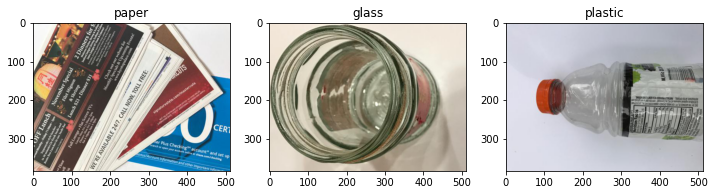

In [2]:
paper = "./archive/garbage_classification/images/paper/paper100.jpg"
glass = "./archive/garbage_classification/images/glass/glass21.jpg"
plastic = "./archive/garbage_classification/images/plastic/plastic21.jpg"

img_paper = Image.open(paper)
img_glass = Image.open(glass)
img_plastic = Image.open(plastic)

plt.figure(figsize=(12,12))
plt.subplot(1, 3, 1)
plt.imshow(img_paper)
plt.axis("on")
plt.title("Paper")

plt.subplot(1, 3, 2)
plt.imshow(img_glass)
plt.axis("on")
plt.title("Glass")

plt.subplot(1, 3, 3)
plt.imshow(img_plastic)
plt.axis("on")
plt.title("Plastic")
plt.show()

Picture's path for each classe.

In [3]:
glass= "./archive/garbage_classification/images/glass/"
paper= "./archive/garbage_classification/images/paper/"
plastic=  "./archive/garbage_classification/images/plastic/"

dict = {}
dict[0] = 'glass'
dict[1] = 'plastic'
dict[2] = 'paper'

## Data Preparation

The dataset is not balanced. Using the data as it is is will probably show wrong results and we may suffer of Overfitting. This means that we need to do some pre processing in order to be able to make conclusions.

Glass: 31.761 % 
Paper: 37.676 % 
Plastic: 30.563 % 


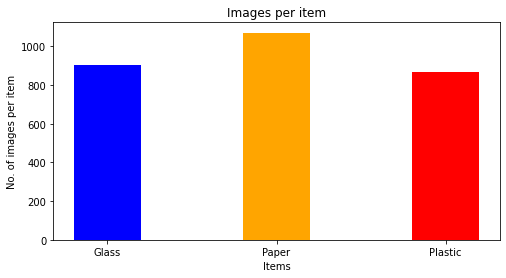

In [4]:
glass_items=902
paper_items=1070
plastic_items=868

print('Glass:', round(glass_items/(glass_items+paper_items+plastic_items) * 100,3), '% ')
print('Paper:', round(paper_items/(glass_items+paper_items+plastic_items) * 100,3),'% ')
print('Plastic:', round(plastic_items/(glass_items+paper_items+plastic_items) * 100,3),'% ')

data = {'Glass': glass_items, 'Paper': paper_items, 'Plastic': plastic_items}
items = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (8, 4))

plt.bar(items[0], values[0], color ='blue',width = 0.4)
plt.bar(items[1], values[1], color ='orange',width = 0.4)
plt.bar(items[2], values[2], color ='red',width = 0.4)

plt.xlabel("Items")
plt.ylabel("No. of images per item")
plt.title("Images per item")
plt.show()

In order of the results above we decided to balance the dataset and only use the same number of images of each classe.

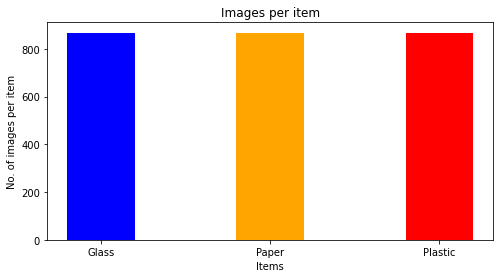

In [5]:
num_images=868 # 868 beacause it is the lowest number from the three classes

data = {'Glass': num_images, 'Paper': num_images, 'Plastic': num_images}
items = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (8, 4))

plt.bar(items[0], values[0], color ='blue',width = 0.4)
plt.bar(items[1], values[1], color ='orange',width = 0.4)
plt.bar(items[2], values[2], color ='red',width = 0.4)

plt.xlabel("Items")
plt.ylabel("No. of images per item")
plt.title("Images per item")
plt.show()

In order to make more easy and lower the number of features we decided to resize each image, beacuse initially the lower size was 512*384 which leads to a higher number of features.

In [6]:
img_size = 32
train_images = []

for p in range(1,num_images+1):
    image = Image.open(glass+"glass"+str(p)+".jpg")
    image = image.resize((img_size, img_size))
    #image = image.convert(mode="L")
    train_images.append(image)

for p in range(1,num_images+1):
    image = Image.open(plastic+"plastic"+str(p)+".jpg")
    image = image.resize((img_size, img_size))
    #image = image.convert(mode="L")
    train_images.append(image)

for p in range(1,num_images+1):
    image = Image.open(paper+"paper"+str(p)+".jpg")
    image = image.resize((img_size, img_size))
    #image = image.convert(mode="L")
    train_images.append(image)

## Data Normalization

In [7]:
X = np.empty((num_images*3, img_size* img_size*3))
index = 0
for pl in train_images:
    # Normalize pixel values
    pixels = asarray(pl)
    pixels = pixels.astype('float32')
    pixels /= 255.0
    X[index] = pixels.reshape(img_size * img_size*3)
    index += 1
g = np.zeros(num_images)
m = np.ones(num_images)
p = np.empty(num_images)
p.fill(2)
y = np.concatenate((g, m, p), axis=0).reshape(X.shape[0], 1)

print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (2604, 3072)
y shape:  (2604, 1)


Splitting the dataset into training subset and testing subset, using 20% fo the dataset to test

In [8]:

y = y.ravel()

# extract train sub-set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling of data
st_x = StandardScaler()    
X_train = st_x.fit_transform(X_train)    
X_test = st_x.transform(X_test) 

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2083, 3072)
y train: (2083,)
X test: (521, 3072)
y test: (521,)


Function to train a specific classifier

In [22]:
def model_train(model, name, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    train_data_accuracy = accuracy_score(y_train, y_train_pred)
    
    y_test_pred = model.predict(X_test)
    test_data_accuracy = accuracy_score(y_test, y_test_pred)

    precision = precision_score(y_test, y_test_pred, average='macro')
    recall = recall_score(y_test, y_test_pred, average='macro')
    f1 = f1_score(y_test, y_test_pred, average='macro')

    print()
    print("- MODEL ANALYSIS")
    print('Precision Score for %s: %0.5f%%' %(name, precision*100))
    print('Recall Score for %s: %0.5f%%' %(name, recall*100))
    print('F1 Score for %s: %0.5f%%' %(name, f1*100))
    print("-------- Accuracy --------")
    print("Accuracy (train) for %s: %0.5f%% " % (name, train_data_accuracy * 100))
    print("Accuracy (test) for %s: %0.5f%% " % (name, test_data_accuracy * 100))
    
    print()
    
    print("-------- Confusion Matrix -------")
    index = ('glass', 'plastic', 'paper')
    cm = confusion_matrix(y_test, y_test_pred)

    dataframe = pd.DataFrame(cm, index=index, columns=index)

    print(dataframe)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()
    
    print()
    print("------- Classification Report -------")
    print( classification_report(y_test, model.predict(X_test)) )

K-fold Cross Validaiton function

In [ ]:
def kfold(model, k, X_train, y_train):
    print("- K-FOLD CROSS-VALIDATION")
    
    kf = KFold(n_splits=k, shuffle=True)
    scores = cross_validate(model, X_train, y_train, scoring="accuracy", cv=k, return_estimator=True)
    return scores["estimator"][np.argmax(scores["test_score"])]

Hypertuned parameters function with GridSearchCV

In [ ]:
def hyperparameters(model, params, X, y):
    print("- FIND HYPERPARAMETERS FOR A MODEL")

    model = GridSearchCV(model, params, scoring="accuracy")
    model.fit(X, y)
    print(" Best Params:", model.best_params_)

    return model.best_params_

## Logistic Regression

Basic model


- MODEL ANALYSIS
Precision Score for Logistic Regression: 85.10597%
Recall Score for Logistic Regression: 84.81143%
F1 Score for Logistic Regression: 84.67285%
-------- Accuracy --------
Accuracy (train) for Logistic Regression: 99.75996% 
Accuracy (test) for Logistic Regression: 84.64491% 

-------- Confusion Matrix -------
         glass  plastic  paper
glass      151       19     11
plastic     13      150      1
paper       17       19    140


/Users/eduardo/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


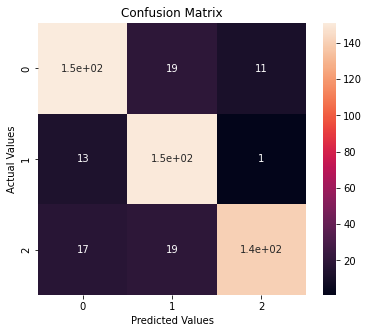


------- Classification Report -------
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83       181
         1.0       0.80      0.91      0.85       164
         2.0       0.92      0.80      0.85       176

    accuracy                           0.85       521
   macro avg       0.85      0.85      0.85       521
weighted avg       0.85      0.85      0.85       521



In [35]:
model = LogisticRegression()
model_train(model,'Logistic Regression', X_train, y_train, X_test, y_test)

K-fold Cross Validation

- K-FOLD CROSS-VALIDATION


/Users/eduardo/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/eduardo/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l


- MODEL ANALYSIS
Precision Score for Logistic Regression K-fold Cross Validation: 85.10597%
Recall Score for Logistic Regression K-fold Cross Validation: 84.81143%
F1 Score for Logistic Regression K-fold Cross Validation: 84.67285%
-------- Accuracy --------
Accuracy (train) for Logistic Regression K-fold Cross Validation: 99.75996% 
Accuracy (test) for Logistic Regression K-fold Cross Validation: 84.64491% 

-------- Confusion Matrix -------
         glass  plastic  paper
glass      151       19     11
plastic     13      150      1
paper       17       19    140


/Users/eduardo/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


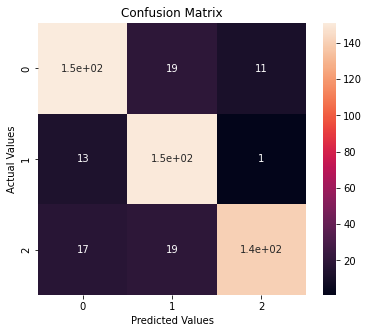


------- Classification Report -------
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83       181
         1.0       0.80      0.91      0.85       164
         2.0       0.92      0.80      0.85       176

    accuracy                           0.85       521
   macro avg       0.85      0.85      0.85       521
weighted avg       0.85      0.85      0.85       521



In [36]:
kfmodel = kfold(model, 5, X_train, y_train)
model_train(kfmodel, 'Logistic Regression K-fold Cross Validation', X_train, y_train, X_test, y_test)

Hypertuned parameters with model from K-fold Cross Validation

- FIND HYPERPARAMETERS FOR A MODEL
 Best Params: {'max_iter': 800, 'multi_class': 'ovr'}

- MODEL ANALYSIS
Precision Score for Logistic Regression Hypertuned parameters: 86.03286%
Recall Score for Logistic Regression Hypertuned parameters: 85.82429%
F1 Score for Logistic Regression Hypertuned parameters: 85.62178%
-------- Accuracy --------
Accuracy (train) for Logistic Regression Hypertuned parameters: 100.00000% 
Accuracy (test) for Logistic Regression Hypertuned parameters: 85.60461% 

-------- Confusion Matrix -------
         glass  plastic  paper
glass      149       20     12
plastic     10      154      0
paper       15       18    143


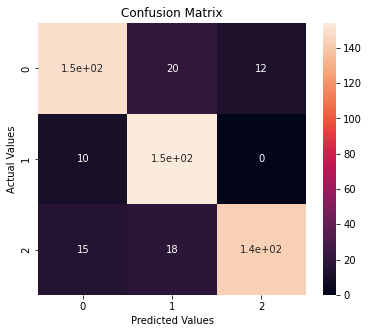


------- Classification Report -------
              precision    recall  f1-score   support

         0.0       0.86      0.82      0.84       181
         1.0       0.80      0.94      0.87       164
         2.0       0.92      0.81      0.86       176

    accuracy                           0.86       521
   macro avg       0.86      0.86      0.86       521
weighted avg       0.86      0.86      0.86       521



In [37]:
model_params = [{'multi_class': ['multinomial', 'ovr'], 'max_iter': [800, 2000, 10000]}]
best_model_params = hyperparameters(kfmodel, model_params , X_train, y_train)

kfmodel.set_params(**best_model_params)
model_train(kfmodel, 'Logistic Regression Hypertuned parameters', X_train, y_train, X_test, y_test)

## Neural Network

Base model


- MODEL ANALYSIS
Precision Score for NN: 91.84835%
Recall Score for NN: 91.89664%
F1 Score for NN: 91.77065%
-------- Accuracy --------
Accuracy (train) for NN: 100.00000% 
Accuracy (test) for NN: 91.74664% 

-------- Confusion Matrix -------
         glass  plastic  paper
glass      160       15      6
plastic      4      159      1
paper       11        6    159


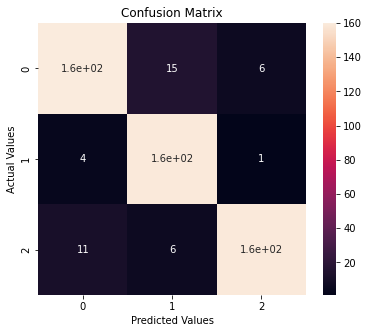


------- Classification Report -------
              precision    recall  f1-score   support

         0.0       0.91      0.88      0.90       181
         1.0       0.88      0.97      0.92       164
         2.0       0.96      0.90      0.93       176

    accuracy                           0.92       521
   macro avg       0.92      0.92      0.92       521
weighted avg       0.92      0.92      0.92       521



In [10]:
model = MLPClassifier()

model_train(model,'NN', X_train, y_train, X_test, y_test)

K-fold Cross Validation

- K-FOLD CROSS-VALIDATION

- MODEL ANALYSIS
Precision Score for NN K-fold Cross Validation: 90.71347%
Recall Score for NN K-fold Cross Validation: 90.69961%
F1 Score for NN K-fold Cross Validation: 90.63048%
-------- Accuracy --------
Accuracy (train) for NN K-fold Cross Validation: 100.00000% 
Accuracy (test) for NN K-fold Cross Validation: 90.59501% 

-------- Confusion Matrix -------
         glass  plastic  paper
glass      161       13      7
plastic      8      155      1
paper       12        8    156


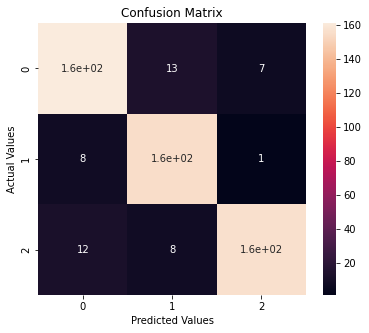


------- Classification Report -------
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89       181
         1.0       0.88      0.95      0.91       164
         2.0       0.95      0.89      0.92       176

    accuracy                           0.91       521
   macro avg       0.91      0.91      0.91       521
weighted avg       0.91      0.91      0.91       521



In [11]:
kfmodel = kfold(model, 5, X_train, y_train)
model_train(kfmodel,'NN K-fold Cross Validation', X_train, y_train, X_test, y_test)

Hypertuned parameters with model from K-fold Cross Validation

- FIND HYPERPARAMETERS FOR A MODEL


/Users/eduardo/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/eduardo/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/eduardo/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/eduardo/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/eduardo/o

 Best Params: {'activation': 'relu', 'alpha': 0.3, 'hidden_layer_sizes': (30,), 'learning_rate': 'constant', 'max_iter': 100, 'solver': 'adam'}

- MODEL ANALYSIS
Precision Score for NN Hypertuned parameters: 91.59936%
Recall Score for NN Hypertuned parameters: 91.71248%
F1 Score for NN Hypertuned parameters: 91.56796%
-------- Accuracy --------
Accuracy (train) for NN Hypertuned parameters: 100.00000% 
Accuracy (test) for NN Hypertuned parameters: 91.55470% 

-------- Confusion Matrix -------
         glass  plastic  paper
glass      159       12     10
plastic      4      159      1
paper        9        8    159


/Users/eduardo/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


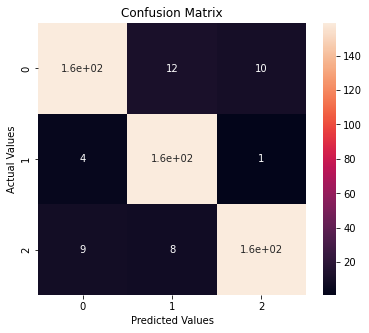


------- Classification Report -------
              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90       181
         1.0       0.89      0.97      0.93       164
         2.0       0.94      0.90      0.92       176

    accuracy                           0.92       521
   macro avg       0.92      0.92      0.92       521
weighted avg       0.92      0.92      0.92       521



In [12]:
mlp_parameters = {
    'hidden_layer_sizes': [(30,), (40,)],
    'max_iter': [100, 200],
    'activation': ['relu', 'logistic'],
    'solver': ['adam'],
    'alpha': [0.3, 0.5, 0.8],
    'learning_rate': ['constant', 'adaptative'],
}

hyper_mlp_parameters = hyperparameters(kfmodel, mlp_parameters , X_train, y_train)
kfmodel.set_params(**hyper_mlp_parameters)
model_train(kfmodel,'NN Hypertuned parameters', X_train, y_train, X_test, y_test)

## Random Forest

Basic model


- MODEL ANALYSIS
Precision Score for RFC: 94.88942%
Recall Score for RFC: 94.86077%
F1 Score for RFC: 94.83484%
-------- Accuracy --------
Accuracy (train) for RFC: 100.00000% 
Accuracy (test) for RFC: 94.81766% 

-------- Confusion Matrix -------
         glass  plastic  paper
glass      170       10      1
plastic      6      158      0
paper        6        4    166


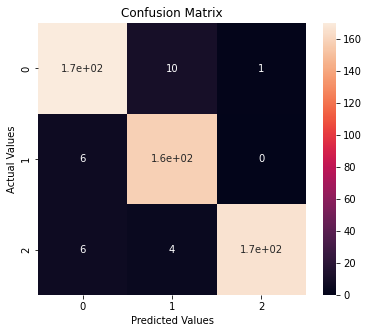


------- Classification Report -------
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94       181
         1.0       0.92      0.96      0.94       164
         2.0       0.99      0.94      0.97       176

    accuracy                           0.95       521
   macro avg       0.95      0.95      0.95       521
weighted avg       0.95      0.95      0.95       521



In [37]:
model = RandomForestClassifier()

model_train(model, 'RFC', X_train, y_train, X_test, y_test)

K-fold Cross Validation

- K-FOLD CROSS-VALIDATION

- MODEL ANALYSIS
Precision Score for RFC K-fold Cross Validation: 94.06193%
Recall Score for RFC K-fold Cross Validation: 94.11365%
F1 Score for RFC K-fold Cross Validation: 94.05955%
-------- Accuracy --------
Accuracy (train) for RFC K-fold Cross Validation: 100.00000% 
Accuracy (test) for RFC K-fold Cross Validation: 94.04990% 

-------- Confusion Matrix -------
         glass  plastic  paper
glass      168        8      5
plastic      5      158      1
paper        6        6    164


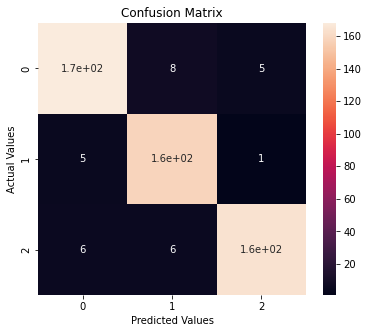


------- Classification Report -------
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.93       181
         1.0       0.92      0.96      0.94       164
         2.0       0.96      0.93      0.95       176

    accuracy                           0.94       521
   macro avg       0.94      0.94      0.94       521
weighted avg       0.94      0.94      0.94       521



In [38]:
kfmodel = kfold(model, 5, X_train, y_train)
model_train(kfmodel,'RFC K-fold Cross Validation', X_train, y_train, X_test, y_test)

Hypertuned parameters with model from K-fold Cross Validation

- FIND HYPERPARAMETERS FOR A MODEL
 Best Params: {'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 350}

- MODEL ANALYSIS
Precision Score for RFC Hypertuned parameters: 95.19589%
Recall Score for RFC Hypertuned parameters: 95.23955%
F1 Score for RFC Hypertuned parameters: 95.20232%
-------- Accuracy --------
Accuracy (train) for RFC Hypertuned parameters: 100.00000% 
Accuracy (test) for RFC Hypertuned parameters: 95.20154% 

-------- Confusion Matrix -------
         glass  plastic  paper
glass      170        8      3
plastic      5      158      1
paper        4        4    168


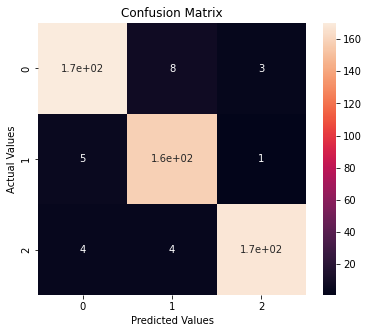


------- Classification Report -------
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.94       181
         1.0       0.93      0.96      0.95       164
         2.0       0.98      0.95      0.97       176

    accuracy                           0.95       521
   macro avg       0.95      0.95      0.95       521
weighted avg       0.95      0.95      0.95       521



In [39]:
rfc_parameters = [{ 
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' :['gini', 'entropy'],
    'min_samples_leaf': [2, 10, 30], 
    'n_estimators': [100, 350, 500]
}]

hyper_rfc_parameters = hyperparameters(kfmodel, rfc_parameters , X_train, y_train)
kfmodel.set_params(**hyper_rfc_parameters)
model_train(kfmodel,'RFC Hypertuned pa  rameters', X_train, y_train, X_test, y_test)

## Decision Tree

Basic model


- MODEL ANALYSIS
Precision Score for DecisionTree: 89.77825%
Recall Score for DecisionTree: 89.70923%
F1 Score for DecisionTree: 89.61889%
-------- Accuracy --------
Accuracy (train) for DecisionTree: 100.00000% 
Accuracy (test) for DecisionTree: 89.63532% 

-------- Confusion Matrix -------
         glass  plastic  paper
glass      164       12      5
plastic      6      153      5
paper       12       14    150


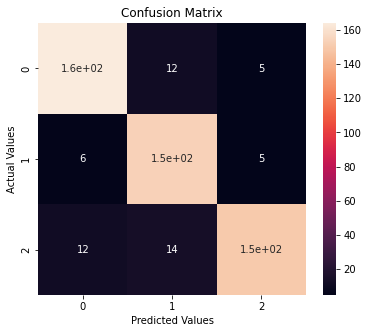


------- Classification Report -------
              precision    recall  f1-score   support

         0.0       0.90      0.91      0.90       181
         1.0       0.85      0.93      0.89       164
         2.0       0.94      0.85      0.89       176

    accuracy                           0.90       521
   macro avg       0.90      0.90      0.90       521
weighted avg       0.90      0.90      0.90       521



In [32]:
model = DecisionTreeClassifier()

model_train(model, 'DecisionTree', X_train, y_train, X_test, y_test)

K-fold Cross Validation

- K-FOLD CROSS-VALIDATION

- MODEL ANALYSIS
Precision Score for DecisionTree: 89.98007%
Recall Score for DecisionTree: 89.97498%
F1 Score for DecisionTree: 89.83406%
-------- Accuracy --------
Accuracy (train) for DecisionTree: 100.00000% 
Accuracy (test) for DecisionTree: 89.82726% 

-------- Confusion Matrix -------
         glass  plastic  paper
glass      160       14      7
plastic      4      157      3
paper       14       11    151


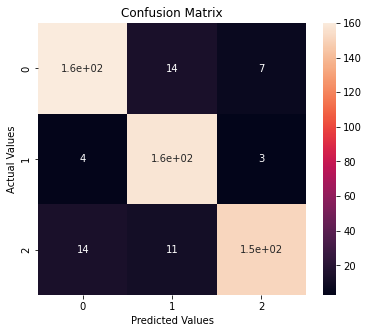


------- Classification Report -------
              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89       181
         1.0       0.86      0.96      0.91       164
         2.0       0.94      0.86      0.90       176

    accuracy                           0.90       521
   macro avg       0.90      0.90      0.90       521
weighted avg       0.90      0.90      0.90       521



In [33]:
kfmodel = kfold(model, 5, X_train, y_train)
model_train(kfmodel,'DecisionTree', X_train, y_train, X_test, y_test)

Hypertuned parameters with model from K-fold Cross Validation

- FIND HYPERPARAMETERS FOR A MODEL
 Best Params: {'criterion': 'gini', 'max_depth': 12}

- MODEL ANALYSIS
Precision Score for DecisionTree: 87.45147%
Recall Score for DecisionTree: 87.08911%
F1 Score for DecisionTree: 86.95713%
-------- Accuracy --------
Accuracy (train) for DecisionTree: 98.07969% 
Accuracy (test) for DecisionTree: 86.94818% 

-------- Confusion Matrix -------
         glass  plastic  paper
glass      158       20      3
plastic      6      153      5
paper       20       14    142


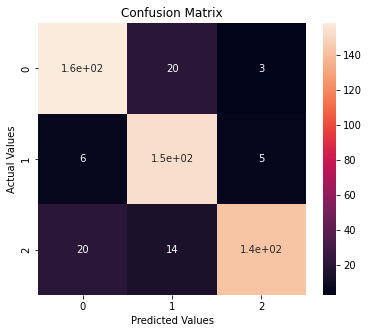


------- Classification Report -------
              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87       181
         1.0       0.82      0.93      0.87       164
         2.0       0.95      0.81      0.87       176

    accuracy                           0.87       521
   macro avg       0.87      0.87      0.87       521
weighted avg       0.88      0.87      0.87       521



In [34]:
dt_parameters = [{'criterion': ['gini', 'entropy'], 'max_depth': [2,4,6,8,10,12]}]
hyper_dt_parameters = hyperparameters(kfmodel, dt_parameters , X_train, y_train)

kfmodel.set_params(**hyper_dt_parameters)
model_train(kfmodel,'DecisionTree', X_train, y_train, X_test, y_test)

## SVM

Basic model


- MODEL ANALYSIS
Precision Score for SVM: 85.21260%
Recall Score for SVM: 85.33832%
F1 Score for SVM: 85.20205%
-------- Accuracy --------
Accuracy (train) for SVM: 93.03889% 
Accuracy (test) for SVM: 85.22073% 

-------- Confusion Matrix -------
         glass  plastic  paper
glass      143       27     11
plastic     11      144      9
paper       14        5    157


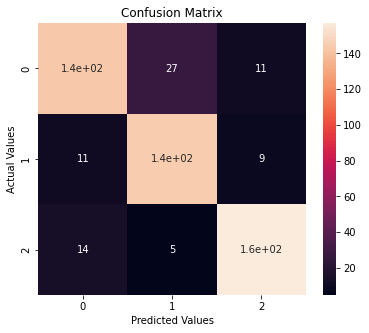


------- Classification Report -------
              precision    recall  f1-score   support

         0.0       0.85      0.79      0.82       181
         1.0       0.82      0.88      0.85       164
         2.0       0.89      0.89      0.89       176

    accuracy                           0.85       521
   macro avg       0.85      0.85      0.85       521
weighted avg       0.85      0.85      0.85       521



In [29]:
model = SVC()

model_train(model, 'SVM', X_train, y_train, X_test, y_test)

K-fold Cross Validation

- K-FOLD CROSS-VALIDATION

- MODEL ANALYSIS
Precision Score for SVM: 85.21260%
Recall Score for SVM: 85.33832%
F1 Score for SVM: 85.20205%
-------- Accuracy --------
Accuracy (train) for SVM: 93.03889% 
Accuracy (test) for SVM: 85.22073% 

-------- Confusion Matrix -------
         glass  plastic  paper
glass      143       27     11
plastic     11      144      9
paper       14        5    157


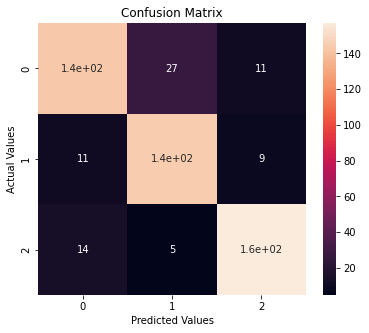


------- Classification Report -------
              precision    recall  f1-score   support

         0.0       0.85      0.79      0.82       181
         1.0       0.82      0.88      0.85       164
         2.0       0.89      0.89      0.89       176

    accuracy                           0.85       521
   macro avg       0.85      0.85      0.85       521
weighted avg       0.85      0.85      0.85       521



In [30]:
kfmodel = kfold(model, 5, X_train, y_train)
model_train(kfmodel, 'SVM', X_train, y_train, X_test, y_test)

Hypertuned parameters with model from K-fold Cross Validation

- FIND HYPERPARAMETERS FOR A MODEL
 Best Params: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

- MODEL ANALYSIS
Precision Score for SVM: 90.36745%
Recall Score for SVM: 90.11446%
F1 Score for SVM: 90.06975%
-------- Accuracy --------
Accuracy (train) for SVM: 100.00000% 
Accuracy (test) for SVM: 90.01919% 

-------- Confusion Matrix -------
         glass  plastic  paper
glass      151        8     22
plastic      7      150      7
paper        6        2    168


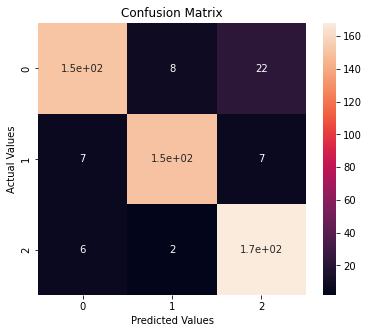


------- Classification Report -------
              precision    recall  f1-score   support

         0.0       0.92      0.83      0.88       181
         1.0       0.94      0.91      0.93       164
         2.0       0.85      0.95      0.90       176

    accuracy                           0.90       521
   macro avg       0.90      0.90      0.90       521
weighted avg       0.90      0.90      0.90       521



In [31]:
svm_parameters = [{'C': [0.01, 0.1, 1, 10, 50, 100, 1000], 
              'gamma': [0.001, 0.01, 0.03, 0.1, 0.3, 1],
              'kernel': ['rbf']}]
best_svm_params = hyperparameters(kfmodel, svm_parameters , X_train, y_train)

kfmodel.set_params(**best_svm_params)
model_train(kfmodel,'SVM', X_train, y_train, X_test, y_test)

## Model Comparison

We are using a box plot to display and compare the results from the models.

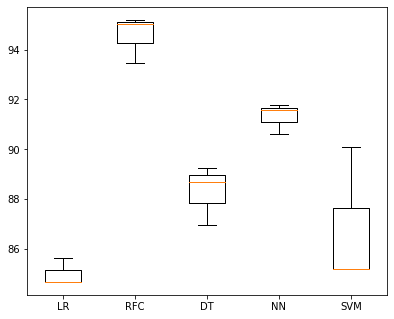

In [40]:
LR = [84.67, 84.67, 85.62]
RFC = [95.03, 93.48, 95.20]
DT = [88.69, 89.25, 86.95]
NN = [91.77, 90.63, 91.57]
SVM = [85.20, 85.20, 90.07]

data = [LR, RFC, DT, NN, SVM]

fig = plt.figure(figsize =(5, 4))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data, labels=["LR", "RFC", "DT", "NN", "SVM"])
 
# show plot
plt.show()
